In [ ]:
!pip install pycaret[full]

In [1083]:
import numpy as np
import pandas as pd

from pycaret.regression import *
from pycaret.utils import *
from sklearn.metrics import mean_squared_error
import datetime

In [1084]:
FEATURE_COLUMNS = ["humidity", "visibility", "windspeedKmph", "tempC", "is_rush_hour", "is_work_hour", "is_night_time", "is_late_night_time"]
CATEGORICAL_COLUMNS = []
USELESS_COLUMNS = ['node_start', 'node_finish', 'lon_start', 'lon_end', 'lat_end', 'lat_start', 'average_speed']

In [1085]:
dataset = pd.read_csv('datasets/big-table-train.csv')
dataset = dataset.drop(columns=[*USELESS_COLUMNS, 'completed_time'])
dataset.loc[dataset["Id"] == -4773019581999572651]

,Id,running_time,route_distance_km,delta_time,distance,speed,cluster_start,cluster_end,is_cluster_loaded_start,is_cluster_loaded_end,is_work_hour,is_night_time,is_late_night_time,is_rush_hour,humidity,visibility,windspeedKmph,tempC,weatherStatus
0,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,31.771489,30.0,67,67,1,1,1,0,0,1,87,10,18,-4,Light snow
1,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,3.673054,24.0,0,0,0,0,1,0,0,1,87,10,18,-4,Light snow
2,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,15.550612,27.0,0,0,0,0,1,0,0,1,87,10,18,-4,Light snow
3,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,50.034390,29.0,84,84,1,1,1,0,0,1,87,10,18,-4,Light snow
4,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,13.453126,30.0,84,84,1,1,1,0,0,1,87,10,18,-4,Light snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,14.094747,37.0,67,67,1,1,1,0,0,1,87,10,18,-4,Light snow
102,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,11.411172,27.0,0,0,0,0,1,0,0,1,87,10,18,-4,Light snow
103,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,31.708492,17.0,0,0,0,0,1,0,0,1,87,10,18,-4,Light snow
104,-4773019581999572651,2022-01-24 18:30:21,3.74,862.0,4.528134,35.0,0,0,0,0,1,0,0,1,87,10,18,-4,Light snow


In [1086]:
dataset_agg = dataset.groupby(['Id', 'running_time', 'route_distance_km', 'delta_time']) \
    .agg({ 
        'distance': ['min', 'max', 'mean', 'std'], 
        'speed': ['min', 'max', 'mean', 'std'], 
        'cluster_start': ['min', 'max', 'mean', 'std'],
        'cluster_end': ['min', 'max', 'mean', 'std'],
        'is_cluster_loaded_start': 'sum',
        'is_cluster_loaded_end': 'sum'
    }).reset_index()
if len(CATEGORICAL_COLUMNS) > 0:
    dataset_agg[CATEGORICAL_COLUMNS] = dataset[CATEGORICAL_COLUMNS]
if len(FEATURE_COLUMNS) > 0:
    dataset_agg[FEATURE_COLUMNS] = dataset[FEATURE_COLUMNS]
dataset_agg = dataset_agg.drop(columns=['Id'])
dataset_agg['running_time'] = (pd.to_datetime(dataset_agg['running_time']) - datetime.datetime(1970,1,1)).dt.total_seconds()
dataset_agg

running_time route_distance_km delta_time  distance              \
                                                      min         max   
0     1.643067e+09             3.179      469.0  2.494184  200.876922   
1     1.643058e+09             6.137      688.0  2.664808  301.851107   
2     1.643064e+09             6.312      683.0  1.261206  201.267382   
3     1.643063e+09             6.379      885.0  1.777369  231.663338   
4     1.643045e+09             2.551      612.0  1.647032  224.340608   
...            ...               ...        ...       ...         ...   
4995  1.643065e+09             5.520      753.0  1.306968  327.558417   
4996  1.643057e+09             3.146      462.0  1.688882  259.418013   
4997  1.643002e+09             4.038      607.0  4.213290  184.102066   
4998  1.643056e+09             1.641      223.0  1.306756   89.077514   
4999  1.643050e+09             2.489      368.0  1.359543  184.070599   

                           speed                   ...  \
           mean        std   min   max       mean  ...   
0     36.177945  34.938977  11.0  43.0  25.987952  ...   
1     51.178833  50.153951  10.0  50.0  29.945455  ...   
2     35.889595  37.219656   7.0  57.0  33.336538  ...   
3     39.080716  42.778210  15.0  52.0  35.449612  ...   
4     31.138847  43.097163   9.0  83.0  24.269231  ...   
...         ...        ...   ...   ...        ...  ...   
4995  35.052090  47.395853  11.0  58.0  33.754658  ...   
4996  30.392428  37.476618  18.0  41.0  30.095960  ...   
4997  49.404830  40.030175   0.0  68.0  38.631579  ...   
4998  25.116555  19.720309  13.0  32.0  24.155556  ...   
4999  48.753847  48.105120  18.0  47.0  30.775510  ...   

     is_cluster_loaded_start is_cluster_loaded_end humidity visibility  \
                         sum                   sum                       
0                         59                    58       87         10   
1                          8                     9       87         10   
2                         47                    48       87         10   
3                         66                    68       87         10   
4                         27                    27       87         10   
...                      ...                   ...      ...        ...   
4995                      44                    42       87         10   
4996                      24                    25       87         10   
4997                      38                    38       87         10   
4998                      17                    16       87         10   
4999                      19                    20       87         10   

     windspeedKmph tempC is_rush_hour is_work_hour is_night_time  \
                                                                   
0               18    -4            1            1             0   
1               18    -4            1            1             0   
2               18    -4            1            1             0   
3               18    -4            1            1             0   
4               18    -4            1            1             0   
...            ...   ...          ...          ...           ...   
4995            18    -4            1            1             0   
4996            18    -4            1            1             0   
4997            18    -4            1            1             0   
4998            18    -4            1            1             0   
4999            18    -4            1            1             0   

     is_late_night_time  
                         
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
4995                  0  
4996                  0  
4997                  0  
4998                  0  
4999                  0  

[5000 rows x 29 columns]

In [1087]:
dataset_agg = pd.DataFrame(dataset_agg.values, columns=['running_time', 'route_distance_km', 'delta_time', 'min_distance', 'max_distance', 'mean_distance', 'std_distance', 'min_speed', 'max_speed', 'mean_speed', 'std_speed', 'min_cluster_start', 'max_cluster_start', 'mean_cluster_start', 'std_cluster_start', 'min_cluster_end', 'max_cluster_end', 'mean_cluster_end', 'std_cluster_end', 'sum_is_cluster_loaded_start', 'sum_is_cluster_loaded_end', *CATEGORICAL_COLUMNS, *FEATURE_COLUMNS])
dataset_agg['delta_time'] = np.log1p(dataset_agg['delta_time'].astype('float'))
dataset_agg

,running_time,route_distance_km,delta_time,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,...,sum_is_cluster_loaded_start,sum_is_cluster_loaded_end,humidity,visibility,windspeedKmph,tempC,is_rush_hour,is_work_hour,is_night_time,is_late_night_time
0,1.643067e+09,3.179,6.152733,2.494184,200.876922,36.177945,34.938977,11.0,43.0,25.987952,...,59.0,58.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
1,1.643058e+09,6.137,6.535241,2.664808,301.851107,51.178833,50.153951,10.0,50.0,29.945455,...,8.0,9.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
2,1.643064e+09,6.312,6.527958,1.261206,201.267382,35.889595,37.219656,7.0,57.0,33.336538,...,47.0,48.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
3,1.643063e+09,6.379,6.786717,1.777369,231.663338,39.080716,42.778210,15.0,52.0,35.449612,...,66.0,68.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
4,1.643045e+09,2.551,6.418365,1.647032,224.340608,31.138847,43.097163,9.0,83.0,24.269231,...,27.0,27.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.643065e+09,5.520,6.625392,1.306968,327.558417,35.052090,47.395853,11.0,58.0,33.754658,...,44.0,42.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
4996,1.643057e+09,3.146,6.137727,1.688882,259.418013,30.392428,37.476618,18.0,41.0,30.095960,...,24.0,25.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
4997,1.643002e+09,4.038,6.410175,4.213290,184.102066,49.404830,40.030175,0.0,68.0,38.631579,...,38.0,38.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
4998,1.643056e+09,1.641,5.411646,1.306756,89.077514,25.116555,19.720309,13.0,32.0,24.155556,...,17.0,16.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0


In [1088]:
dataset_agg

,running_time,route_distance_km,delta_time,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,...,sum_is_cluster_loaded_start,sum_is_cluster_loaded_end,humidity,visibility,windspeedKmph,tempC,is_rush_hour,is_work_hour,is_night_time,is_late_night_time
0,1.643067e+09,3.179,6.152733,2.494184,200.876922,36.177945,34.938977,11.0,43.0,25.987952,...,59.0,58.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
1,1.643058e+09,6.137,6.535241,2.664808,301.851107,51.178833,50.153951,10.0,50.0,29.945455,...,8.0,9.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
2,1.643064e+09,6.312,6.527958,1.261206,201.267382,35.889595,37.219656,7.0,57.0,33.336538,...,47.0,48.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
3,1.643063e+09,6.379,6.786717,1.777369,231.663338,39.080716,42.778210,15.0,52.0,35.449612,...,66.0,68.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
4,1.643045e+09,2.551,6.418365,1.647032,224.340608,31.138847,43.097163,9.0,83.0,24.269231,...,27.0,27.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.643065e+09,5.520,6.625392,1.306968,327.558417,35.052090,47.395853,11.0,58.0,33.754658,...,44.0,42.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
4996,1.643057e+09,3.146,6.137727,1.688882,259.418013,30.392428,37.476618,18.0,41.0,30.095960,...,24.0,25.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
4997,1.643002e+09,4.038,6.410175,4.213290,184.102066,49.404830,40.030175,0.0,68.0,38.631579,...,38.0,38.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0
4998,1.643056e+09,1.641,5.411646,1.306756,89.077514,25.116555,19.720309,13.0,32.0,24.155556,...,17.0,16.0,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0


In [1089]:
data = dataset_agg.sample(frac=0.9, random_state=786)
data_unseen = dataset_agg.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (4500, 29)
Unseen Data For Predictions: (500, 29)


In [1090]:
s = setup(data = data, target = 'delta_time', categorical_features=CATEGORICAL_COLUMNS, session_id=123, use_gpu=False, normalize = True)

,Description,Value
0,Session id,123
1,Target,delta_time
2,Target type,Regression
3,Original data shape,"(4500, 29)"
4,Transformed data shape,"(4500, 29)"
5,Transformed train set shape,"(3150, 29)"
6,Transformed test set shape,"(1350, 29)"
7,Numeric features,28
8,Preprocess,True
9,Imputation type,simple


In [1091]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.1749,0.0560,0.2359,0.6435,0.0331,0.0281,0.2410
lightgbm,Light Gradient Boosting Machine,0.1772,0.0571,0.2381,0.6365,0.0335,0.0285,0.0690
et,Extra Trees Regressor,0.1785,0.0573,0.2386,0.6354,0.0335,0.0287,0.2730
rf,Random Forest Regressor,0.1768,0.0575,0.2389,0.6343,0.0336,0.0285,0.5690
br,Bayesian Ridge,0.2020,0.0698,0.2637,0.5553,0.0368,0.0324,0.0200
ridge,Ridge Regression,0.2021,0.0699,0.2640,0.5544,0.0368,0.0325,0.0190
lr,Linear Regression,0.2022,0.0701,0.2642,0.5536,0.0369,0.0325,0.4310
huber,Huber Regressor,0.2012,0.0706,0.2652,0.5500,0.0370,0.0324,0.0500
ada,AdaBoost Regressor,0.2212,0.0753,0.2740,0.5195,0.0380,0.0351,0.1060
omp,Orthogonal Matching Pursuit,0.2117,0.0778,0.2785,0.5038,0.0388,0.0340,0.0180


In [1092]:
best_model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1713,0.0563,0.2372,0.6304,0.0332,0.0272
1,0.1876,0.0685,0.2618,0.5600,0.0367,0.0301
2,0.1929,0.0695,0.2637,0.5689,0.0368,0.0309
3,0.1603,0.0449,0.2119,0.7171,0.0298,0.0259
4,0.1786,0.0551,0.2347,0.6395,0.0331,0.0289
5,0.1839,0.0617,0.2483,0.6397,0.0351,0.0299
6,0.1688,0.0467,0.2161,0.6831,0.0302,0.0272
7,0.1684,0.0515,0.2268,0.6575,0.0318,0.0270
8,0.1789,0.0602,0.2454,0.6563,0.0352,0.0292


In [1093]:
tuned_best_model = tune_model(best_model, n_iter=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1840,0.0642,0.2534,0.5781,0.0356,0.0293
1,0.1858,0.0696,0.2639,0.5530,0.0370,0.0297
2,0.2041,0.0775,0.2784,0.5195,0.0389,0.0327
3,0.1677,0.0503,0.2243,0.6831,0.0314,0.0270
4,0.1835,0.0586,0.2420,0.6167,0.0342,0.0298
5,0.1932,0.0674,0.2595,0.6065,0.0370,0.0316
6,0.1735,0.0517,0.2274,0.6492,0.0320,0.0279
7,0.1785,0.0560,0.2366,0.6275,0.0331,0.0287
8,0.1888,0.0649,0.2548,0.6295,0.0365,0.0309


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


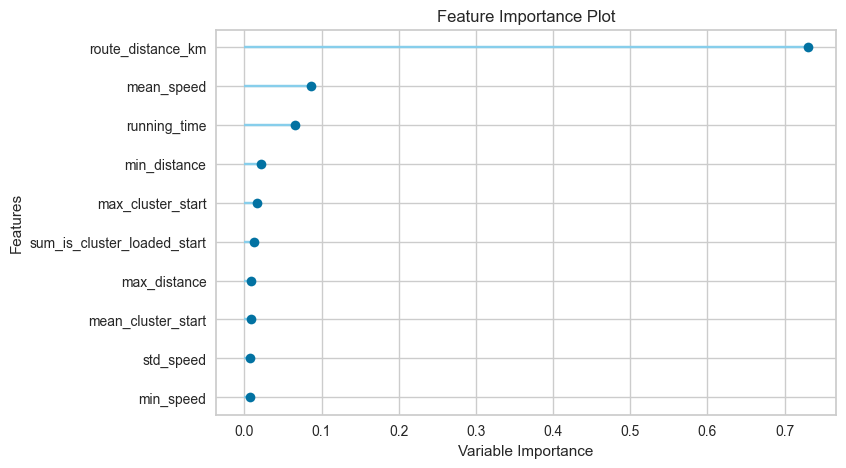

In [1094]:
plot_model(tuned_best_model, 'feature')

In [563]:
interpret_model(tuned_best_model)

ModuleNotFoundError: 
'shap' is a soft dependency and not included in the pycaret installation. Please run: `pip install shap` to install.
Alternately, you can install this by running `pip install pycaret[analysis]`

In [1095]:
# validate on unseen data
unseen_predictions = predict_model(tuned_best_model, data=data_unseen)
unseen_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1674,0.0548,0.2341,0.6642,0.0331,0.0272


,running_time,route_distance_km,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,std_speed,...,humidity,visibility,windspeedKmph,tempC,is_rush_hour,is_work_hour,is_night_time,is_late_night_time,delta_time,prediction_label
0,1.643062e+09,1.722,6.701660,169.959030,47.297234,39.016899,28.0,50.0,42.000000,6.018490,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,5.446737,5.719770
1,1.643014e+09,4.547,1.114897,170.198868,36.442673,34.675922,18.0,48.0,31.432432,7.596197,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,6.646390,6.669330
2,1.643045e+09,3.328,1.820466,212.768417,46.869915,39.129139,7.0,31.0,24.718750,4.413071,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,6.658011,6.472944
3,1.643063e+09,7.871,1.078196,600.626282,36.311298,56.201584,12.0,54.0,34.002357,8.476689,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,6.845880,6.733562
4,1.642994e+09,2.501,2.641901,155.466187,46.309536,39.334789,27.0,59.0,35.714287,8.314799,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,5.780744,5.871376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.643015e+09,5.371,1.786217,171.588715,45.862732,42.692673,18.0,61.0,39.982143,11.681958,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,6.510258,6.649886
496,1.643051e+09,3.427,5.170965,268.783508,48.007847,53.165791,10.0,44.0,28.307692,9.881279,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,5.860786,6.206599
497,1.643031e+09,3.094,1.968851,267.655762,44.337429,51.252708,0.0,48.0,28.257143,6.555639,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,6.395262,6.365848
498,1.643006e+09,7.662,0.757768,203.738800,38.268856,41.577263,15.0,62.0,38.905262,9.188299,...,87.0,10.0,18.0,-4.0,1.0,1.0,0.0,0.0,6.792345,6.795031


In [1096]:
(mean_squared_error(np.expm1(unseen_predictions['delta_time']), np.expm1(unseen_predictions['prediction_label']), squared=False))

121.62685601269943

### Model predictions on test data

In [1097]:
test_dataset = pd.read_csv("datasets/big-table-test.csv")
test_dataset = test_dataset.drop(columns=USELESS_COLUMNS)

test_dataset

,Id,running_time,route_distance_km,distance,speed,cluster_start,cluster_end,is_cluster_loaded_start,is_cluster_loaded_end,is_work_hour,is_night_time,is_late_night_time,is_rush_hour,humidity,visibility,windspeedKmph,tempC,weatherStatus
0,6198,2022-01-24 03:38:30,4.744,138.795710,37.0,1,1,0,0,0,0,1,0,84,10,24,-5,Clear
1,6198,2022-01-24 03:38:30,4.744,95.273001,33.0,8,8,0,0,0,0,1,0,84,10,24,-5,Clear
2,6198,2022-01-24 03:38:30,4.744,137.647881,35.0,79,8,1,0,0,0,1,0,84,10,24,-5,Clear
3,6198,2022-01-24 03:38:30,4.744,4.383708,30.0,1,1,0,0,0,0,1,0,84,10,24,-5,Clear
4,6198,2022-01-24 03:38:30,4.744,24.195593,31.0,30,30,0,0,0,0,1,0,84,10,24,-5,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102537,527850,2022-01-24 18:45:20,10.127,40.933260,45.0,82,82,1,1,1,0,0,1,87,10,18,-4,Light snow
102538,527850,2022-01-24 18:45:20,10.127,63.421598,34.0,82,52,1,1,1,0,0,1,87,10,18,-4,Light snow
102539,527850,2022-01-24 18:45:20,10.127,4.303810,16.0,52,52,1,1,1,0,0,1,87,10,18,-4,Light snow
102540,527850,2022-01-24 18:45:20,10.127,5.250640,37.0,52,52,1,1,1,0,0,1,87,10,18,-4,Light snow


In [1098]:
prediction_agg = test_dataset.groupby(['Id', 'running_time', 'route_distance_km']) \
    .agg({
        'distance': ['min', 'max', 'mean', 'std'], 
        'speed': ['min', 'max', 'mean', 'std'],
        'cluster_start': ['min', 'max', 'mean', 'std'],
        'cluster_end': ['min', 'max', 'mean', 'std'],
        'is_cluster_loaded_start': 'sum',
        'is_cluster_loaded_end': 'sum'
    }).reset_index()
if len(CATEGORICAL_COLUMNS) > 0:
    prediction_agg[CATEGORICAL_COLUMNS] = test_dataset[CATEGORICAL_COLUMNS]
if len(FEATURE_COLUMNS) > 0:
    prediction_agg[FEATURE_COLUMNS] = test_dataset[FEATURE_COLUMNS]
prediction_agg = prediction_agg.drop(columns=['Id'])
prediction_agg['running_time'] = (pd.to_datetime(prediction_agg['running_time']) - datetime.datetime(1970,1,1)).dt.total_seconds()
prediction_agg['delta_time'] = 0
prediction_agg

running_time route_distance_km  distance                         \
                                          min         max       mean   
0    1.642996e+09             4.744  2.670344  393.497710  52.880472   
1    1.642996e+09             6.279  2.836942  436.138845  36.270614   
2    1.642996e+09             3.934  0.857178  292.340750  55.012732   
3    1.642997e+09             5.959  0.306712  247.943670  33.236916   
4    1.642997e+09             7.028  0.153356  203.740575  36.920702   
..            ...               ...       ...         ...        ...   
995  1.643050e+09             2.897  4.078611  274.618389  48.263068   
996  1.643050e+09             3.482  3.207770  233.844636  38.275375   
997  1.643050e+09             3.486  1.974970  137.592949  27.527613   
998  1.643050e+09             0.703  2.004086  126.478060  31.932694   
999  1.643050e+09            10.127  1.309023  600.626182  44.331345   

               speed                              ... is_cluster_loaded_end  \
           std   min   max       mean        std  ...                   sum   
0    61.845189  14.0  72.0  47.573034  12.983283  ...                     5   
1    46.198626  14.0  65.0  41.424419  11.920795  ...                   105   
2    58.488516  21.0  56.0  39.929577   9.457157  ...                    42   
3    37.770876   6.0  61.0  37.832402  11.829541  ...                    31   
4    40.248515  13.0  68.0  38.363158  12.544933  ...                    74   
..         ...   ...   ...        ...        ...  ...                   ...   
995  55.255577  14.0  54.0  38.116667  11.370631  ...                    30   
996  41.604237  11.0  58.0  37.021978  10.375161  ...                    35   
997  25.461119   9.0  57.0  36.816000   9.140819  ...                    18   
998  34.065373  23.0  53.0  35.818182   9.624554  ...                    22   
999  58.991960  12.0  71.0  48.289474  13.467352  ...                    67   

    humidity visibility windspeedKmph tempC is_rush_hour is_work_hour  \
                                                                        
0         84         10            24    -5            0            0   
1         84         10            24    -5            0            0   
2         84         10            24    -5            0            0   
3         84         10            24    -5            0            0   
4         84         10            24    -5            0            0   
..       ...        ...           ...   ...          ...          ...   
995       83         10            24    -5            0            0   
996       83         10            24    -5            0            0   
997       83         10            24    -5            0            0   
998       83         10            24    -5            0            0   
999       83         10            24    -5            0            0   

    is_night_time is_late_night_time delta_time  
                                                 
0               0                  1          0  
1               0                  1          0  
2               0                  1          0  
3               0                  1          0  
4               0                  1          0  
..            ...                ...        ...  
995             0                  1          0  
996             0                  1          0  
997             0                  1          0  
998             0                  1          0  
999             0                  1          0  

[1000 rows x 29 columns]

In [1099]:
prediction_agg = pd.DataFrame(prediction_agg.values, columns=['running_time', 'route_distance_km', 'delta_time', 'min_distance', 'max_distance', 'mean_distance', 'std_distance', 'min_speed', 'max_speed', 'mean_speed', 'std_speed', 'min_cluster_start', 'max_cluster_start', 'mean_cluster_start', 'std_cluster_start', 'min_cluster_end', 'max_cluster_end', 'mean_cluster_end', 'std_cluster_end', 'sum_is_cluster_loaded_start', 'sum_is_cluster_loaded_end', *CATEGORICAL_COLUMNS, *FEATURE_COLUMNS])

In [1100]:
prediction_agg

,running_time,route_distance_km,delta_time,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,...,sum_is_cluster_loaded_start,sum_is_cluster_loaded_end,humidity,visibility,windspeedKmph,tempC,is_rush_hour,is_work_hour,is_night_time,is_late_night_time
0,1.642996e+09,4.744,2.670344,393.497710,52.880472,61.845189,14.0,72.0,47.573034,12.983283,...,5.0,84.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0
1,1.642996e+09,6.279,2.836942,436.138845,36.270614,46.198626,14.0,65.0,41.424419,11.920795,...,105.0,84.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0
2,1.642996e+09,3.934,0.857178,292.340750,55.012732,58.488516,21.0,56.0,39.929577,9.457157,...,42.0,84.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0
3,1.642997e+09,5.959,0.306712,247.943670,33.236916,37.770876,6.0,61.0,37.832402,11.829541,...,31.0,84.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0
4,1.642997e+09,7.028,0.153356,203.740575,36.920702,40.248515,13.0,68.0,38.363158,12.544933,...,74.0,84.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.643050e+09,2.897,4.078611,274.618389,48.263068,55.255577,14.0,54.0,38.116667,11.370631,...,30.0,83.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0
996,1.643050e+09,3.482,3.207770,233.844636,38.275375,41.604237,11.0,58.0,37.021978,10.375161,...,35.0,83.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0
997,1.643050e+09,3.486,1.974970,137.592949,27.527613,25.461119,9.0,57.0,36.816000,9.140819,...,18.0,83.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0
998,1.643050e+09,0.703,2.004086,126.478060,31.932694,34.065373,23.0,53.0,35.818182,9.624554,...,22.0,83.0,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0


In [1101]:
data_prediction = prediction_agg
data_prediction.reset_index(drop=True, inplace=True)

In [1102]:
data_prediction.shape

(1000, 29)

In [1103]:
submission_df = pd.read_csv("datasets/submission.csv")
submission_df

,Id,Predicted
0,6198,0
1,6417,0
2,7054,0
3,9628,0
4,10283,0
...,...,...
995,525706,0
996,526604,0
997,527213,0
998,527520,0


In [1104]:
submission_predictions = predict_model(tuned_best_model, data=data_prediction)
submission_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4.7589,24.8346,4.9834,-9.8170,1.2800,11.9948


,running_time,route_distance_km,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,std_speed,...,humidity,visibility,windspeedKmph,tempC,is_rush_hour,is_work_hour,is_night_time,is_late_night_time,delta_time,prediction_label
0,1.642995e+09,4.744,393.497711,52.880474,61.845188,14.0,72.0,47.573032,12.983283,1.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,2.670344,6.527581
1,1.642996e+09,6.279,436.138855,36.270615,46.198627,14.0,65.0,41.424419,11.920795,1.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,2.836942,6.687581
2,1.642996e+09,3.934,292.340759,55.012733,58.488518,21.0,56.0,39.929577,9.457157,0.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,0.857178,6.592740
3,1.642997e+09,5.959,247.943665,33.236916,37.770878,6.0,61.0,37.832401,11.829541,1.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,0.306712,6.623025
4,1.642997e+09,7.028,203.740570,36.920700,40.248516,13.0,68.0,38.363159,12.544933,1.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,0.153356,6.664385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.643050e+09,2.897,274.618378,48.263069,55.255577,14.0,54.0,38.116665,11.370630,1.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,4.078611,6.183202
996,1.643050e+09,3.482,233.844635,38.275375,41.604237,11.0,58.0,37.021976,10.375160,1.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,3.207770,6.265445
997,1.643050e+09,3.486,137.592957,27.527613,25.461119,9.0,57.0,36.816002,9.140820,1.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,1.974970,6.202930
998,1.643050e+09,0.703,126.478058,31.932693,34.065372,23.0,53.0,35.818180,9.624554,84.0,...,10.0,24.0,-5.0,0.0,0.0,0.0,1.0,0.0,2.004086,6.040881


In [1105]:
result_df = submission_predictions["prediction_label"].reset_index()
result_df.shape

(1000, 2)

In [1106]:
submission_df["Predicted"] = np.expm1(result_df["prediction_label"])

In [1107]:
submission_df.to_csv("datasets/submission.csv", index=False)

## Submission phase

Guide: https://www.kaggle.com/code/derrickmwiti/how-to-make-submissions-using-kaggle-s-api/notebook

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ["KAGGLE_USERNAME"]="beardimon"
os.environ["KAGGLE_KEY"]="22adc3776f244a54f4732bf8dfb077eb"

In [ ]:
!kaggle competitions submit -c int20h-2023-hackathon  -f ./datasets/submission.csv -m "Baseline"

In [ ]:
!kaggle competitions leaderboard -c int20h-2023-hackathon --show

In [ ]:
!kaggle competitions submissions -c int20h-2023-hackathon